In [28]:
import pandas as pd
import numpy as np 
import re 
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords
from wordcloud import WordCloud
from pprint import pprint

# Using Wordnet for lemmatization
#nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer

from gensim import corpora
from gensim.models import LsiModel
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt

In [29]:
df = pd.read_csv("../beforecovid.csv")
df.head()

,Date,text,Year,Month,clean_text,join_clean_text,real_Date
0,25-Jan-19,"Mine is a 20 years resale flat, was top in 199...",19,Jan,"['mine', '20', 'years', 'resale', 'flat', 'top...",mine 20 years resale flat top 1999 got bomb sh...,2019-01-25
1,25-Jan-19,kimurayuki said:\r\nMine is a 20 years resale ...,19,Jan,"['kimurayuki', 'mine', '20', 'years', 'resale'...",kimurayuki mine 20 years resale flat top 1999 ...,2019-01-25
2,18-Jan-19,punggolbto said:\r\nAs per the actual HDB mode...,19,Jan,"['punggolbto', 'per', 'actual', 'hdb', 'models...",punggolbto per actual hdb models floor plans p...,2019-01-18
3,19-Oct-18,I have just purchased a resale flat recently w...,18,Oct,"['purchased', 'resale', 'flat', 'recently', 'w...",purchased resale flat recently without agent u...,2018-10-19
4,20-Oct-18,"Just to add, go to hdb website and check recen...",18,Oct,"['add', 'go', 'hdb', 'website', 'check', 'rece...",add go hdb website check recent 6mths resale t...,2018-10-20


In [30]:
df['clean_text'].head()

0    ['mine', '20', 'years', 'resale', 'flat', 'top...
1    ['kimurayuki', 'mine', '20', 'years', 'resale'...
2    ['punggolbto', 'per', 'actual', 'hdb', 'models...
3    ['purchased', 'resale', 'flat', 'recently', 'w...
4    ['add', 'go', 'hdb', 'website', 'check', 'rece...
Name: clean_text, dtype: object

In [31]:
len(df['clean_text'][0])

564

In [32]:
# remove punc 
df['clean_text']  = df['join_clean_text'].map(lambda x: re.sub("[^A-Za-z0-9]+"," ", str(x)))
# lower case
df['clean_text']  = df['clean_text'].apply(lambda x: x.lower())
# remove words with length < 2
df['clean_text'] = df['clean_text'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))

# tokenize
df['clean_text']  = [word_tokenize(row) for row in df['clean_text']]
# remove stopwords
stop_words = stopwords.words('english')
new_stop_words = ['u','m','lol','condo','said','also',"click","expand","http","www","com","https",'from', 'subject', 're', 'edu', 'use']
stop_words.extend(new_stop_words)

def remove_stopwords(text):
    return [w for w in text if w not in stop_words]
df['clean_text']  = df['clean_text'].apply(lambda x: remove_stopwords(x))

In [33]:
# lemmatize
def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(w) for w in text]

df['clean_text'] = df['clean_text'].apply(lemmatize_text)

In [34]:
from nltk.util import ngrams
def make_bigrams(texts):
    texts = ["_".join(w) for w in ngrams(texts, 2)]
    return texts

df['clean_text'] = df['clean_text'].apply(lambda x: make_bigrams(x))
df.head()

,Date,text,Year,Month,clean_text,join_clean_text,real_Date
0,25-Jan-19,"Mine is a 20 years resale flat, was top in 199...",19,Jan,"[mine_year, year_resale, resale_flat, flat_top...",mine 20 years resale flat top 1999 got bomb sh...,2019-01-25
1,25-Jan-19,kimurayuki said:\r\nMine is a 20 years resale ...,19,Jan,"[kimurayuki_mine, mine_year, year_resale, resa...",kimurayuki mine 20 years resale flat top 1999 ...,2019-01-25
2,18-Jan-19,punggolbto said:\r\nAs per the actual HDB mode...,19,Jan,"[punggolbto_per, per_actual, actual_hdb, hdb_m...",punggolbto per actual hdb models floor plans p...,2019-01-18
3,19-Oct-18,I have just purchased a resale flat recently w...,18,Oct,"[purchased_resale, resale_flat, flat_recently,...",purchased resale flat recently without agent u...,2018-10-19
4,20-Oct-18,"Just to add, go to hdb website and check recen...",18,Oct,"[add_hdb, hdb_website, website_check, check_re...",add go hdb website check recent 6mths resale t...,2018-10-20


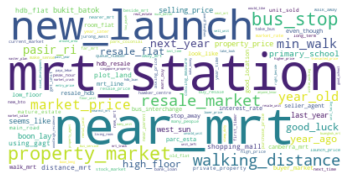

In [35]:
# Word Cloud

description_str = ''
for word_list in df['clean_text'].values:
    description_str += ' '.join(row for row in word_list) + ' '
    
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3, stopwords = stop_words,
                      contour_color='steelblue', collocations = False,  random_state=1)

# Generate a word cloud
wordcloud.generate(description_str)

# Visualize the word cloud
# wordcloud.to_file("wordcloud_before_covid.png")

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### LSA Topic Modelling

#### Prepare Corpus

In [36]:
# de-tokenization
detokenized_doc = df['clean_text'].tolist()

In [37]:
# Create Dictionary
id2word = corpora.Dictionary(detokenized_doc)
# Filter out tokens that appear in only 1 documents and appear in more than 90% of the documents
id2word.filter_extremes(no_below=2, no_above=0.9)
# Create Corpus
texts = detokenized_doc
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

In [38]:
# Create a dictionary representation of the documents. Each word gets an id
print('Sample word to id mappings:\n', list(id2word.items())[:50])
print()
print('Total Vocabulary Size:', len(id2word))

Sample word to id mappings:
 [(0, '1999_got'), (1, 'aircon_ledge'), (2, 'bay_crazyclubx'), (3, 'bomb_shelter'), (4, 'bought_punggol'), (5, 'buy_wait'), (6, 'change_buy'), (7, 'clearly_heard'), (8, 'crazyclubx_last'), (9, 'door_clearly'), (10, 'door_haiz'), (11, 'end_peace'), (12, 'external_traffic'), (13, 'flat_top'), (14, 'forever_least'), (15, 'got_bomb'), (16, 'haiz_end'), (17, 'haiz_noisy'), (18, 'hdb_stayed'), (19, 'hear_noise'), (20, 'heard_hdb'), (21, 'home_haiz'), (22, 'house_thought'), (23, 'inconsiderate_upstairs'), (24, 'knew_rather'), (25, 'last_time'), (26, 'least_change'), (27, 'ledge_noise'), (28, 'loading_bay'), (29, 'mine_year'), (30, 'move_slamming'), (31, 'neighbour_pain'), (32, 'noise_external'), (33, 'noise_slamming'), (34, 'noisy_inconsiderate'), (35, 'peace_knew'), (36, 'punggol_house'), (37, 'rather_rent'), (38, 'rent_forever'), (39, 'rent_unfortunately'), (40, 'resale_flat'), (41, 'sell_move'), (42, 'shelter_aircon'), (43, 'slamming_door'), (44, 'stayed_hear'),

#### Hyperparameter Tuning

#### Helpers

In [40]:
def prepare_corpus(doc_clean):

    """
    Input  : clean document
    Purpose: create term dictionary of our courpus and Converting list of documents (corpus) into Document Term Matrix
    Output : term dictionary and Document Term Matrix
    """
    # Creating the term dictionary of our courpus, where every unique term is assigned an index. dictionary = corpora.Dictionary(doc_clean)
    dictionary = corpora.Dictionary(doc_clean)
    # Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
    # generate LDA model

    return dictionary, doc_term_matrix

In [41]:
def create_gensim_lsa_model(doc_clean, number_of_topics, words):

    """
    Input  : clean document, number of topics and number of words associated with each topic
    Purpose: create LSA model using gensim
    Output : return LSA model
    """
    dictionary,doc_term_matrix = prepare_corpus(doc_clean)
    # generate LSA model
    lsamodel = LsiModel(doc_term_matrix, num_topics = number_of_topics, id2word = dictionary)  # train model
    print(lsamodel.print_topics(num_topics = number_of_topics, num_words = words))

    return lsamodel

In [42]:
def compute_coherence_values(dictionary, doc_term_matrix, doc_clean, stop, start=2, step=3):

    """
    Input   : dictionary : Gensim dictionary
              corpus : Gensim corpus
              texts : List of input texts
              stop : Max num of topics
    purpose : Compute c_v coherence for various number of topics
    Output  : model_list : List of LSA topic models
              coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for number_of_topics in range(start, stop, step):
        # generate LSA model
        model = LsiModel(doc_term_matrix, num_topics = number_of_topics, id2word = dictionary, chunksize = 100)  # train model
        model_list.append(model)
        coherencemodel = CoherenceModel(model = model, texts = doc_clean, dictionary = dictionary, coherence = 'c_v')
        coherence_values.append(coherencemodel.get_coherence())
    
    return model_list, coherence_values

In [43]:
def plot_graph(doc_clean, start, stop, step):
    dictionary, doc_term_matrix = prepare_corpus(doc_clean)
    model_list, coherence_values = compute_coherence_values(dictionary, doc_term_matrix,doc_clean,
                                                            stop, start, step)
    # Show graph
    x = range(start, stop, step)
    plt.plot(x, coherence_values)
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()

C:\Users\randy\anaconda3\lib\site-packages\gensim\topic_coherence\direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
C:\Users\randy\anaconda3\lib\site-packages\gensim\topic_coherence\indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


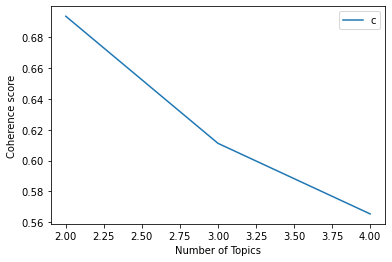

In [17]:
detokenized_doc = df['clean_text'].tolist()
start, stop, step = 2, 20, 1
plot_graph(detokenized_doc, start, stop, step)

### Building LSA Model 

In [44]:
number_of_topics = 10
words = 10
model = create_gensim_lsa_model(detokenized_doc, number_of_topics, words)

[(0, '-0.635*"boon_lay" + -0.278*"jurong_west" + -0.226*"lay_way" + -0.200*"mrt_station" + -0.196*"bto_site" + -0.117*"west_street" + -0.112*"foreign_worker" + -0.100*"jurong_point" + -0.098*"bus_interchange" + -0.092*"near_mrt"'), (1, '0.271*"parc_clematis" + 0.247*"whistler_grand" + 0.247*"kent_ridge" + 0.246*"ridge_hill" + 0.245*"new_launch" + 0.218*"entry_price" + 0.203*"bedroom_entry" + 0.196*"dairy_farm" + 0.183*"sale_district" + 0.183*"district_average"'), (2, '0.409*"wing_tai" + 0.276*"per_cent" + 0.148*"drop_price" + 0.131*"cheng_say" + 0.130*"property_market" + 0.126*"property_price" + 0.099*"price_despite" + 0.099*"virus_outbreak" + 0.098*"despite_virus" + 0.089*"belief_property"'), (3, '-0.279*"nov_2018" + -0.184*"tengah_mrt" + -0.175*"bukit_batok" + -0.121*"tengah_plantation" + -0.117*"mrt_station" + -0.103*"affected_sound" + -0.095*"batok_road" + -0.089*"good_school" + -0.088*"500m_away" + -0.084*"plantation_mrt"'), (4, '0.581*"mrt_station" + 0.249*"near_mrt" + 0.243*"new

In [45]:
pprint(model.print_topics())

[(0,
  '-0.635*"boon_lay" + -0.278*"jurong_west" + -0.226*"lay_way" + '
  '-0.200*"mrt_station" + -0.196*"bto_site" + -0.117*"west_street" + '
  '-0.112*"foreign_worker" + -0.100*"jurong_point" + -0.098*"bus_interchange" '
  '+ -0.092*"near_mrt"'),
 (1,
  '0.271*"parc_clematis" + 0.247*"whistler_grand" + 0.247*"kent_ridge" + '
  '0.246*"ridge_hill" + 0.245*"new_launch" + 0.218*"entry_price" + '
  '0.203*"bedroom_entry" + 0.196*"dairy_farm" + 0.183*"sale_district" + '
  '0.183*"district_average"'),
 (2,
  '0.409*"wing_tai" + 0.276*"per_cent" + 0.148*"drop_price" + '
  '0.131*"cheng_say" + 0.130*"property_market" + 0.126*"property_price" + '
  '0.099*"price_despite" + 0.099*"virus_outbreak" + 0.098*"despite_virus" + '
  '0.089*"belief_property"'),
 (3,
  '-0.279*"nov_2018" + -0.184*"tengah_mrt" + -0.175*"bukit_batok" + '
  '-0.121*"tengah_plantation" + -0.117*"mrt_station" + -0.103*"affected_sound" '
  '+ -0.095*"batok_road" + -0.089*"good_school" + -0.088*"500m_away" + '
  '-0.084*"plan

In [46]:
coherence_model_lsa = CoherenceModel(model=model, texts=detokenized_doc, dictionary=id2word, coherence='c_v')
coherence_lsa = coherence_model_lsa.get_coherence()
print('Coherence Score: ', coherence_lsa)

#Not sure why this has an error. It works for LSA - Unigram.

KeyError: 187408